### Python import

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

In [ ]:
# 구글 드라이브 접속

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load Data

In [ ]:
# 훈련
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/mnist_data/train.csv')
# 검증
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/mnist_data/test.csv')
# 제출용 
submission = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/mnist_data/submission.csv')

### EDA

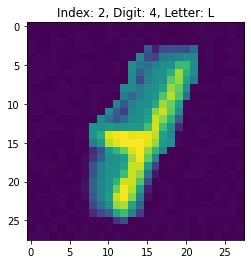

In [ ]:
# 데이터 확인(idx 변경으로 다른 파일 확인 가능) 

idx = 2
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int) # 28*28 꼴의 이미지로 변환한 이미지를 img에 담기
digit = train.loc[idx, 'digit'] # 해당 이미지의 숫자(미리 넣어놓은 답안)
letter = train.loc[idx, 'letter'] # 해당 이미지의 문자(미리 넣어놓은 답안)

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

### Train model

In [ ]:
# 모델 설계, 훈련

def one_hot_encoder(x): # 1개만 Hot(True)이고 나머지는 Cold(False) -> One hot endoding
    y = np.zeros((len(x), len(np.unique(x)))) # x의 길이만큼 모든 값이 0인 벡터 생성. np.unique(x) : x의 중복된 성분을 제외한 배열 반환
    for i, num in enumerate(x):
        y[i][num] = 1 # Label에 해당하는 인덱스에 1 입력
    return y

# CNN은 이미지 파일을 그대로 받는다.(28*28, 1채널) 훈련 파일을 이렇게 이미지 파일이 나열된 벡터로 만들어야 CNN에서 잘 처리할 수 있다.
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28,28,1) # shape 변경 (784크기가 6만개)

# 픽셀 값을 0~1 사이 값으로 변환 (너무 큰 값이 들어가면 함수의 계수들이 작아질 위험이 생김(0.0000023 등) -> 계수들의 학습이 불안정해짐.)
# 정규화의 목적 -> input의 범위와 output의 크기를 맞춰주기 위함 -> 계산 과정에서 생기는 위험 줄임)
x_train = x_train / 255 # 입력 데이터의 최대값이 255라 255로 나눠주는 것

# Label의 원-핫 인코딩 실행(배열 train_label을 벡터로 만들어줌 -> 이렇게 만들고 학습하면 잘됨. 분류 문제에서는 거의 one hot encording을 수행한다.)
y_train = one_hot_encoder(train['digit']) # 결과값(답안)을 one-hot encoder 기법으로 {1,0,0,...} 꼴의 벡터들의 리스트로 생성.

In [ ]:
# 훈련 데이터로 모델 생성 

def create_cnn_model(x_train):

# 입력 데이터 가공
  inputs = tf.keras.layers.Input(x_train.shape[1:]) # 입력 데이터를 뽑아낸다. 

  bn = tf.keras.layers.BatchNormalization()(inputs) # BatchNormalization : 배치 정규화. 스케일을 조정해 학습시 일어나는 왜곡 현상을 보정해줌. 안정적인 학습을 가능하게 해줘 높은 학습률로 학습 시킬 수 있게 해준다. 
  conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu')(bn)  # 배치 정규화한 입력 데이터를 2차원 배열 컨볼루전 연산. 커널 개수가 128개로 하고(커널을 8개로 할 때 보다 더많은 특징을 잡을 수 있다.) 커널 사이즈는 5*5사이즈로 한다. 
  bn = tf.keras.layers.BatchNormalization()(conv) #컨볼루전 연산한 것을 또다시 배치 정규화.
  conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 배치 정규화한 것을 또다시 컨볼루전 연산한다. 
  pool = tf.keras.layers.MaxPooling2D((2, 2))(conv) # MaxPooling 레이어(이미지 학습할 때 많이 사용. MaxPooling2D : 이미지 크기를 줄여주는 함수. (2*2)단위로 이미지를 축소해서 쓴다. 

# 축소한 것을 앞서 한 것처럼 배치 정규화, 컨볼루전 연산을 거친 뒤 마지막에 MaxPooling 레이어를 적용해 크기를 줄임으로써 데이터를 학습하기 편하게 가공해준다. 
  bn = tf.keras.layers.BatchNormalization()(pool) # 배치 정규화.
  conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 컨볼루전 연산 
  bn = tf.keras.layers.BatchNormalization()(conv) # 배치 정규화
  conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn) # 컨볼루전 연산
  pool = tf.keras.layers.MaxPooling2D((2, 2))(conv) # MaxPooling

# Flatten 레이어. 1열로 쭉 늘린다. [x, x, x, x,...]
  flatten = tf.keras.layers.Flatten()(pool)

# 배치 정규화를 통해 안정적인 데이터로 만들어준다. 
  bn = tf.keras.layers.BatchNormalization()(flatten)
# Dense Layer을 사용해 완전 연결 계층으로 생성 (Fully-Connected Layer). Dense : 입,출력을 모두 연결하는 레이어
  dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

# 출력 
  bn = tf.keras.layers.BatchNormalization()(dense) # 배치 정규화
  outputs = tf.keras.layers.Dense(10, activation='softmax')(bn) # 배치 정규화한 것을 완전 연결 계층으로 만든다.

# 모델 생성
  model = tf.keras.models.Model(inputs=inputs, outputs=outputs) # 가공한 입, 출력 파일을 넣어 모델 생성

  return model # 생성한 모델을 반환

In [ ]:
model = create_cnn_model(x_train)                                                         # 모델 만들기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    # 컴파일, Loss = CrossEntropy, 최적화: Adam

# 체크 포인트 저장
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.01, patience=3, verbose=0, mode='max', # min_delta 변화 정도가 0.01보다 작으면 변하지 않았다고 가정 -> stop. 예 : 기울기가 0.01에서 0.015가 되었을 경우 변함 없다고 판단, 훈련 중지
    baseline=None, restore_best_weights=True # patience : 점수가 떨어져도 봐주는 횟수. patience = 1이면 한 번만 점수 떨어져도 바로 훈련 종료 # mode='max' : '점수가 높을 수록 좋아지는 것'을 알려줌. min, auto 등이 있다. auto는 EarlyStopping험수가 알아서 판단한다. 
)

# 모델 훈련
model.fit(x_train, y_train, 
          epochs=100, batch_size=8, 
          validation_split=0.2, # 훈련 데이터 중 20%를 검증 데이터로 사용(전체 x,y 중 20%를 검증 세트로 사용)
          shuffle=True,         # 매 epoch 마다 데이터 섞기 -> 일반적인 모델 생성 가능
          callbacks=[early_stopping] # 콜백 함수 지정(리스트 형태로 넣어줌)
         )      
# 손실 함수는 다중 분류 손실함수(one-hot encoding 형태로 결과값이 나온다. 그래서 실제 출력값과 비교할 때 실제 출력값도 one-hot encoding 과정을 거쳐야 한다. )
# 글자, 문자 구분하는데 있어서 categorical_crossentropy 방식이 효율적이라는 생각이 든다. 
# 그리고 최적화 함수로 Adam을 쓰고 있는데 이는 과거의 학습률들을 이용해 가중치, 중첩을 조정. 
# 모멘텀(이전 상태를 그대로 가져오는 것)을 활용해 이전에 많이 변경시킨 것은 계속 크게 변경시키고 적게 변경시킨 것은 계속 적게 변경시킴.(학습률이랑 연관해서 생각)
model.summary()

Epoch 1/100
205/205 [==============================] - 51s 250ms/step - loss: 2.7889 - accuracy: 0.3779 - val_loss: 14.5870 - val_accuracy: 0.1073
Epoch 2/100
205/205 [==============================] - 51s 248ms/step - loss: 1.4203 - accuracy: 0.5781 - val_loss: 5.3264 - val_accuracy: 0.1634
Epoch 3/100
205/205 [==============================] - 51s 250ms/step - loss: 1.0421 - accuracy: 0.6673 - val_loss: 1.8042 - val_accuracy: 0.4951
Epoch 4/100
205/205 [==============================] - 51s 250ms/step - loss: 0.8188 - accuracy: 0.7326 - val_loss: 1.4463 - val_accuracy: 0.6073
Epoch 5/100
205/205 [==============================] - 51s 249ms/step - loss: 0.7040 - accuracy: 0.7656 - val_loss: 1.1869 - val_accuracy: 0.6976
Epoch 6/100
205/205 [==============================] - 51s 249ms/step - loss: 0.5533 - accuracy: 0.8162 - val_loss: 1.3370 - val_accuracy: 0.6780
Epoch 7/100
205/205 [==============================] - 51s 250ms/step - loss: 0.4790 - accuracy: 0.8449 - val_loss: 1.2165 

In [ ]:
model = create_cnn_model(x_train)                                                         # 모델 만들기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    # 컴파일, Loss = CrossEntropy, 최적화: Adam

# 모델 폴더 만들기
model_path = 'model/'
if not os.path.exists(model_path): # model_path가 없으면 
    os.mkdir(model_path) # model_path생성

# 체크 포인트 저장(kera.callbacks 안에 콜백 함수들이 들어있다. )
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path + 'Epoch_{epoch:03d}_Val_{val_accuracy:.3f}.hdf5', #파일명(모델에 따라 epoch횟수, validation 정확도 등을 담아서 표기하면 좋다.) 구분 잘되게끔 이름 지어주기. 점수가 좋아질 때마다 저장된다.
    monitor='val_accuracy', verbose=0, save_best_only=True) # 어떤 평가점수를 보고 stop할건지 정해줌. val_accuracy를 기준으로 stop여부를 평가하는 것이 더 객관적.

# 모델 훈련
history = model.fit(
    x_train, y_train, 
    epochs=50, batch_size=8, 
    validation_split=0.2, shuffle=True,
    callbacks=[checkpoint] # 체크포인트 삽입. callbacks=[checkpoint, earlyStopping] 등 콜백 함수로 여러개 쓸 수 있다. 이렇게 되면 체크 포인트 생성과 동시에 정확도 떨어지면 훈련 중단한다. 
    #reduceLR도 같이 사용하면 더 좋은 모델을 생성할 수 있다. 
)      

Epoch 1/50
205/205 [==============================] - 52s 252ms/step - loss: 2.9072 - accuracy: 0.3547 - val_loss: 12.4128 - val_accuracy: 0.1073
Epoch 2/50
205/205 [==============================] - 52s 251ms/step - loss: 1.3977 - accuracy: 0.5635 - val_loss: 8.6584 - val_accuracy: 0.1171
Epoch 3/50
205/205 [==============================] - 51s 251ms/step - loss: 1.0619 - accuracy: 0.6569 - val_loss: 2.3976 - val_accuracy: 0.4146
Epoch 4/50
205/205 [==============================] - 51s 251ms/step - loss: 0.8131 - accuracy: 0.7326 - val_loss: 1.4662 - val_accuracy: 0.6244
Epoch 5/50
205/205 [==============================] - 51s 251ms/step - loss: 0.6973 - accuracy: 0.7582 - val_loss: 1.4213 - val_accuracy: 0.6463
Epoch 6/50
205/205 [==============================] - 51s 251ms/step - loss: 0.5912 - accuracy: 0.7979 - val_loss: 1.1238 - val_accuracy: 0.6854
Epoch 7/50
205/205 [==============================] - 54s 263ms/step - loss: 0.5142 - accuracy: 0.8266 - val_loss: 1.2281 - val_a

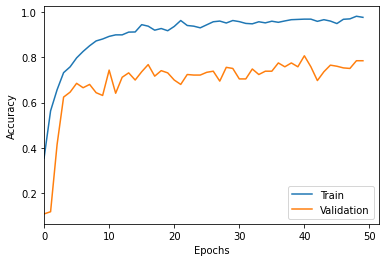

In [ ]:
#baseline모델이 너무 커서 오차가 많이 나는 듯. 

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(left=0)
plt.show()


# 모든 파일 가져오기
import glob
filelist = glob.glob('model/*') #filelist안에 model폴더 안에 있는 모든 파일 저장 -> 데이터 많을 때 이런 방법 사용
# 파일 저장할 때 정확도 순으로 저장되기 때문에(그렇게 되도록 이름을 지었다) 가장 마지막에 있는 파일을 가져오면 가장 높은 정확도의 모델을 가져올 수 있다. 
model.load_weights(filelist[-1]) # 가장 마지막에 있는 모델 가져오기 -> 이를 이용해 예측하는 것이 가장 높은 정확도를 보일 가능성이 크다. 

### Predict

In [ ]:
# 모델 검증.

x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

# weigth_file = glob('model/*.hdf5')[-1] # 체크포인트로 만들었던 모든 파일 가져오고 그 중 가장 마지막 파일(정확도가 높은 파일) 올리기 
# model.load_weights(weigth_file)

# submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

,id,digit
0,2049,1
1,2050,1
2,2051,1
3,2052,1
4,2053,1


In [ ]:
#baseline.csv에 저장
submission.to_csv('/content/gdrive/My Drive/Colab Notebooks/mnist_data/baseline.csv', index=False)

# 데이콘에서와 값이 다른 이유 : 서로 테스트 데이터 세트가 달라서 그럼. -> 그래도 어느정도 비슷하게 가니 val_accuracy로 보는게 그나마 객관적이라 할 수 있다. 